In [3]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [4]:
import hickle

from ase.io import read

import numpy as np

import torch
torch.set_default_dtype(torch.float64)

from mlelec.data.qmdataset import QMDataset
from mlelec.data.mldataset import MLDataset
from mlelec.models.linear_integrated import LinearModelPeriodic
from mlelec.utils.pbc_utils import blocks_to_matrix
from mlelec.utils.twocenter_utils import _to_uncoupled_basis, unfix_orbital_order
from mlelec.metrics import Eigval_loss, L2_loss_meanzero, L2_loss
import metatensor.torch as mts
from metatensor.learn import DataLoader

import os
os.environ["PYSCFAD_BACKEND"] = "torch"
from pyscf import gto
from pyscfad import numpy as pynp
from pyscfad import ops
from pyscfad.ml.scf import hf
import pyscf.pbc.tools.pyscf_ase as pyscf_ase
from mlelec.data.pyscf_calculator import _instantiate_pyscf_mol

import xitorch
from xitorch.linalg import symeig

from matplotlib import pyplot as plt

from IPython.utils import io as ipy_io

In [5]:
import os
os.environ["PYSCFAD_BACKEND"] = "torch"

In [6]:
from pyscf import gto


In [7]:
from pyscfad import numpy as pynp


In [8]:
from pyscfad import ops


In [9]:
import os
os.environ["PYSCFAD_BACKEND"] = "torch"
from pyscf import gto
from pyscfad import numpy as pynp
from pyscfad import ops
from pyscfad.ml.scf import hf


In [10]:
orbitals = {
    'sto-3g': {1: [[1,0,0]], 
               5: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               6: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               7: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]],
               8: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]]
               }, 
    
    'def2svp': {1: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]],
                6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]],
                8: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]
                },
    'def2tzvp': {
    6: [
        # 5S
        [1, 0, 0],
        [2, 0, 0],
        [3, 0, 0],
        [4, 0, 0],
        [5, 0, 0],
        # 3P
        [2, 1, 1],
        [2, 1, -1],
        [2, 1, 0],
        [3, 1, 1],
        [3, 1, -1],
        [3, 1, 0],
        [4, 1, 1],
        [4, 1, -1],
        [4, 1, 0],
        # 2D
        [3, 2, -2],
        [3, 2, -1],
        [3, 2, 0],
        [3, 2, 1],
        [3, 2, 2],
        [4, 2, -2],
        [4, 2, -1],
        [4, 2, 0],
        [4, 2, 1],
        [4, 2, 2],
        # 1F
        [4, 3, -3],
        [4, 3, -2],
        [4, 3, -1],
        [4, 3, 0],
        [4, 3, 1],
        [4, 3, 2],
        [4, 3, 3]
    ],

     1: [
         # 3S
         [1, 0, 0], 
         [2, 0, 0], 
         [3, 0, 0], 
         # 1P
         [2, 1, -1], 
         [2, 1, 0], 
         [2, 1, 1]
     ]
}
}

device = 'cpu'

In [11]:
max_radial  = 12
max_angular = 6
atomic_gaussian_width = 0.3
cutoff = 3.5

hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.5}}}

hypers_atom = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': 0.5,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.5}}}


return_rho0ij = False
both_centers = False
LCUT = 4

# QMD

In [12]:
workdir = '/scratch/pegolo/ethane'
every = 20

For the moment, we need to create multiple QMDataset (analogous to MoleculeDataset), one for the large basis, one for the small one.

In [13]:
qmdata = QMDataset.from_file(
    frames_path = f'{workdir}/ethane.xyz', 
    fock_realspace_path = f'{workdir}/b3lypg_def2tzvp/focks.npy', 
    overlap_realspace_path = f'{workdir}/b3lypg_def2tzvp/ovlps.npy',
    dimension = 0, 
    device = 'cpu', 
    orbs_name='def2tzvp', 
    orbs=orbitals['def2tzvp'], 
    frame_slice = f'::{every}',
)

In [14]:
qmdata_sto3G = QMDataset.from_file(
    frames_path = f'{workdir}/ethane.xyz', 
    dimension = 0,
    fock_realspace_path = f'{workdir}/b3lypg_sto3g/fock.hickle',
    overlap_realspace_path = f'{workdir}/b3lypg_sto3g/ovlp_nscf.hickle',
    device = device, 
    orbs = orbitals['sto-3g'], 
    orbs_name = 'sto-3g',
    frame_slice = f'::{every}',
)

# MLD

In [220]:
from mlelec.data.mldataset import MLDataset
mldata_sto3g = MLDataset(qmdata_sto3G, 
                   item_names = ['fock_blocks', 'fock_realspace', 'overlap_realspace', 'eigenvalues', 'atom_resolved_density', 'dipoles'],
                   # features = mldata.features,
                   cutoff = hypers_pair['cutoff'],
                   hypers_atom = hypers_atom,
                   hypers_pair = hypers_pair,
                   lcut = 3,
                   train_frac = 0.7,
                   val_frac = 0.2,
                   test_frac = 0.1,
                   shuffle = False,
                   model_basis = orbitals['sto-3g'],
                   fix_p_orbital_order = True,
                  )

cpu pair features
cpu single center features
cpu single center features


In [209]:
from mlelec.data.mldataset import MLDataset
mldata = MLDataset(qmdata, 
                   item_names = ['fock_blocks', 'fock_realspace', 'overlap_realspace', 'eigenvalues', 'atom_resolved_density', 'dipoles'],
                   features = mldata.features,
                   cutoff = hypers_pair['cutoff'],
                   hypers_atom = hypers_atom,
                   hypers_pair = hypers_pair,
                   lcut = 3,
                   train_frac = 0.7,
                   val_frac = 0.2,
                   test_frac = 0.1,
                   shuffle = False,
                   model_basis = orbitals['sto-3g'],
                   model_basis_name = 'sto-3g',
                   fix_p_orbital_order = True,
                   aux_overlap_realspace = qmdata_sto3G.overlap_realspace
                  )

# Model

Initialize the model

In [211]:
from mlelec.models.equivariant_nonlinear_lightning import LitEquivariantNonlinearModel, MSELoss
from mlelec.models.equivariant_nonlinear_lightning import MLDatasetDataModule
from mlelec.callbacks.logging import LoggingCallback
from mlelec.callbacks.progress_bar import ProgressBar

import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping

# Assuming you have `train_dataset`, `val_dataset`, and `test_dataset`
data_module = MLDatasetDataModule(mldata, batch_size=8, num_workers=0)

# Initialize with custom loss function and keyword arguments for derived predictions

model = LitEquivariantNonlinearModel(
    mldata=mldata,
    nhidden=16,
    nlayers=1,
    activation='SiLU',
    apply_norm=True,
    learning_rate=1e-3,
    loss_fn=MSELoss(),
    optimizer='adam',
    is_indirect=True,
    eigenvalues=True,
    atom_resolved_density=True,
)

In [212]:
logger = TensorBoardLogger("tb_logs", name="ethane")

In [213]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00,
    patience=100,
    verbose=False,
    mode='min'
)

In [214]:
progress_bar = ProgressBar()
logger_callback = LoggingCallback(log_every_n_epochs = 5)

In [215]:
trainer = pl.Trainer(max_epochs=500, 
                     accelerator='cpu', 
                     # logger = logger, 
                     # log_every_n_steps = 1, 
                     check_val_every_n_epoch=10,
                     callbacks=[early_stopping, progress_bar]
                     # callbacks=[early_stopping, logger_callback],
                     # enable_progress_bar=False
                    )

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [216]:
trainer.fit(model, data_module)

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/lightning/pytorch/core/optimizer.py:316: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.

  | Name  | Type                      | Params | Mode 
------------------------------------------------------------
0 | model | EquivariantNonlinearModel | 784 K  | train
------------------------------------------------------------
784 K     Trainable params
0         Non-trainable params
784 K     Total params
3.137     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [217]:
trainer.test(model, data_module)

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric         ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ rmse_atom_resolved_density │     0.1987265087223138     │
│      rmse_eigenvalues      │    0.10508036902518607     │
│         test_loss          │     13.520862802424698     │
└────────────────────────────┴────────────────────────────┘

[{'test_loss': 13.520862802424698,
  'rmse_eigenvalues': 0.10508036902518607,
  'rmse_atom_resolved_density': 0.1987265087223138}]

In [218]:
pred = model.predict(mldata_sto3g.items.features, target_properties=['eigenvalues', 'atom_resolved_density', 'dipoles'])

In [223]:
mldata_sto3g.items.dipoles

tensor([[-0.0101,  0.0796, -0.0323],
        [-0.0507,  0.0078, -0.0505],
        [ 0.0488,  0.0755, -0.0551],
        [-0.0168,  0.2695,  0.1000],
        [ 0.0194, -0.0122, -0.0399],
        [ 0.0196, -0.0347,  0.0090],
        [ 0.0653,  0.2127, -0.0669],
        [-0.0444,  0.0508, -0.1086],
        [ 0.0399,  0.0242, -0.0221],
        [ 0.0186,  0.0856,  0.0475],
        [ 0.0204,  0.0159,  0.0408],
        [ 0.0262, -0.0088, -0.0107],
        [-0.0004,  0.1124, -0.0355],
        [ 0.0804, -0.0715,  0.0276],
        [-0.0229, -0.0983, -0.1474],
        [ 0.0618, -0.0275, -0.1246],
        [-0.0723,  0.0091, -0.0628],
        [-0.0371,  0.0082, -0.0221],
        [-0.0107,  0.0647, -0.0648],
        [-0.0209,  0.0374,  0.0599],
        [-0.0390,  0.0648, -0.0530],
        [ 0.0038,  0.0695, -0.0717],
        [ 0.0209,  0.0124,  0.0771],
        [-0.0214, -0.0005,  0.0614],
        [ 0.0187, -0.0843, -0.0792],
        [-0.0308,  0.0023,  0.0894],
        [ 0.0168, -0.0526, -0.0390],
 

16 torch.Size([98])
64 torch.Size([64])
3 torch.Size([3])
16 torch.Size([98])
64 torch.Size([64])
3 torch.Size([3])


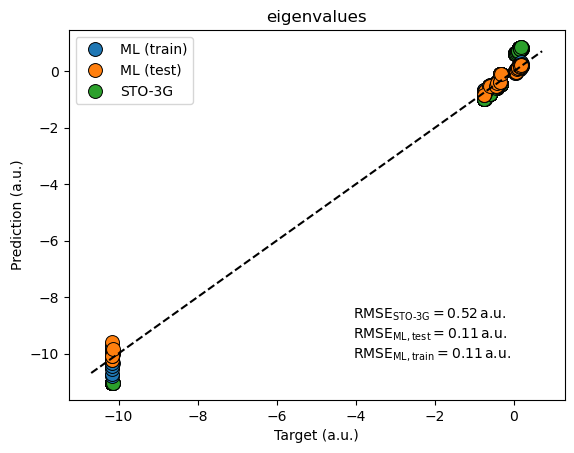

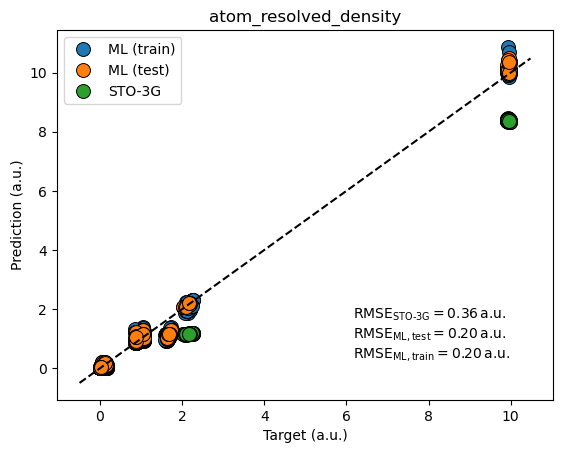

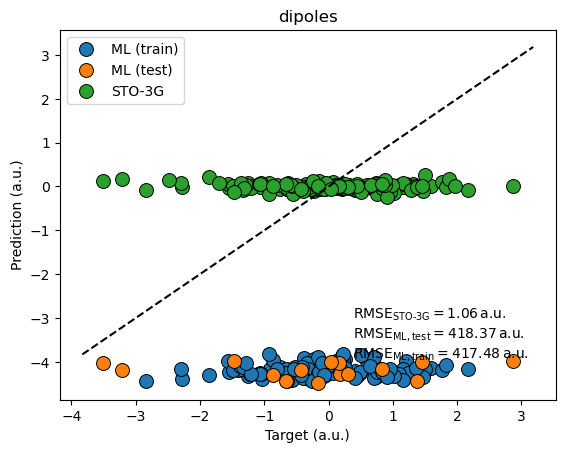

In [227]:
n_eig = pred.eigenvalues[0].shape[0]

figs = {}
axes = {}
m = 'o'
ms = 10
mew = .7
xtext = 0.55
ytext = 0.1
idxs = [mldata.train_idx, mldata.test_idx]
lbls = ['train', 'test']
dy = 0.055

# ML
for i, (idx, lbl) in enumerate(zip(idxs, lbls)):

    for k, y in pred._asdict().items():
        if k == 'fock_blocks':
            continue

        if k == 'dipoles':
            f = 1/100
        else:
            f = 1

        if k not in figs:
            figs[k], axes[k] = plt.subplots()

        sh = y[0].shape[0]
        y = torch.stack([y[i] for i in idx]).flatten()
        print(sh, mldata.items._asdict()[k][0].shape)
        x = torch.stack([mldata.items._asdict()[k][i][:sh] for i in idx]).flatten()
        axes[k].plot(x, y*f, m, label = f'ML ({lbl})', 
                     markeredgewidth = mew,
                     markeredgecolor = 'k',
                     markersize = ms, 
                     zorder = 1)

        rmse = np.sqrt(np.mean((x.numpy()-y.numpy())**2))
        axes[k].text(xtext, ytext + dy*i, fr'$\mathrm{{RMSE_{{ML,{lbl}}}}}={rmse:.2f}\,$a.u.', transform=ax.transAxes, ha = 'left', va = 'bottom')
# STO-3G
for k in axes:
    try:
        y = torch.stack(mldata_sto3g.items._asdict()[k]).flatten()
    except:
        y = mldata_sto3g.items._asdict()[k].flatten()
        
    sh = mldata_sto3g.items._asdict()[k][0].shape[0]
    try:
        x = torch.stack(mldata.items._asdict()[k])[:, :sh].flatten()
    except:
        x = mldata.items._asdict()[k][:, :sh].flatten()
    axes[k].plot(x, y, m, label = 'STO-3G', zorder=0,
                markeredgewidth = mew,
                markeredgecolor = 'k',
                markersize = ms, 
                )
    
    rmse = np.sqrt(np.mean((x.numpy()-y.numpy())**2))
    axes[k].text(xtext, ytext+dy*len(lbls), fr'$\mathrm{{RMSE_{{STO\text{{-}}3G}}}}={rmse:.2f}\,$a.u.', transform=ax.transAxes, ha = 'left', va = 'bottom')
        
for k, ax in axes.items():
    
    ax.legend()
    ax.set_xlabel('Target (a.u.)')
    ax.set_ylabel('Prediction (a.u.)')
    xmin,xmax=ax.get_xlim()
    ax.plot([xmin,xmax], [xmin,xmax], '--k')
    ax.set_title(k)

# TODO: check dipoles. The difference between STO-3G and def3-svf is bizarre

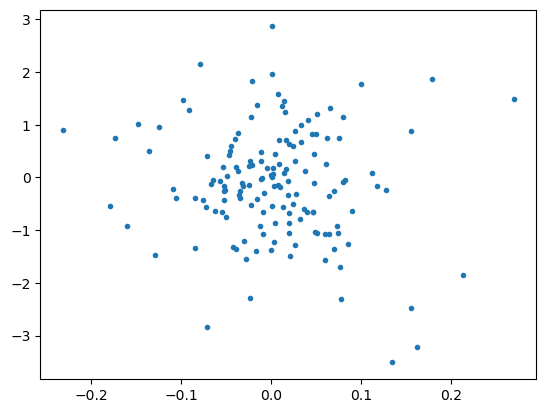

In [229]:
plt.plot(mldata_sto3g.items.dipoles.flatten(), mldata.items.dipoles.flatten(), '.')

In [200]:
batch = next(iter(test_dl))
print(batch.sample_id)

dl_frames = [qmdata.structures[A] for A in batch.sample_id]
dl_frames_dict = {A: f for A, f in zip(batch.sample_id, dl_frames)}
pred = model(batch.features, mldata.model_metadata)

HT = blocks_to_matrix(pred, mldata.model_basis, dl_frames_dict, detach = True)
HT = [h[0,0,0] for h in HT]

# Predictions need fixing/unfixing the orbital order
fock_predictions = unfix_orbital_order(
    torch.stack(HT),
    dl_frames,
    qmdata_sto3G.basis
)
over_predictions = unfix_orbital_order(
    batch.overlap_realspace,
    dl_frames,
    qmdata_sto3G.basis
)

# QMDataset does NOT need fixing/unfixing the orbital order
fock_targets = torch.stack([qmdata.fock_realspace[i] for i in batch.sample_id])
over_targets = torch.stack([qmdata.overlap_realspace[i] for i in batch.sample_id])

fock_sto3g = torch.stack([qmdata_sto3G.fock_realspace[i] for i in batch.sample_id])
over_sto3g = torch.stack([qmdata_sto3G.overlap_realspace[i] for i in batch.sample_id])

with ipy_io.capture_output():
    dipole_targets = compute_dipole_moment(
        dl_frames,
        fock_targets,
        over_targets,
        qmdata.basis_name)

with ipy_io.capture_output():
    dipole_predictions = compute_dipole_moment(
        dl_frames,
        fock_predictions,
        over_predictions,
        qmdata_sto3G.basis_name)

with ipy_io.capture_output():
    dipole_sto3g = compute_dipole_moment(
        dl_frames,
        fock_sto3g,
        over_sto3g,
        qmdata_sto3G.basis_name)

(45, 46, 47, 48, 49)


NameError: name 'compute_dipole_moment' is not defined

Text(0, 0.5, 'Predicted dipoles (D)')

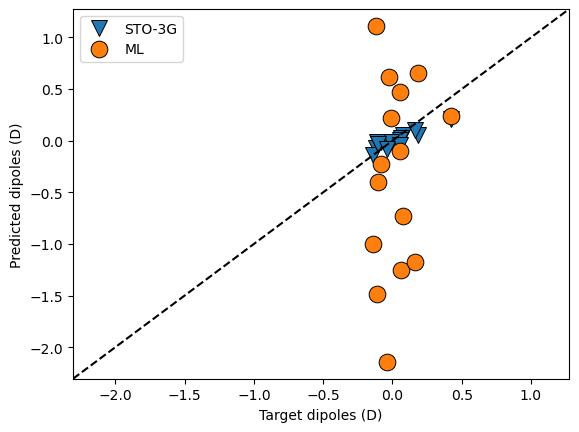

In [349]:
from ase.units import Bohr, Debye
au_to_debye = Bohr/Debye

ms = 12
mew = .7

fig, ax = plt.subplots()

x = dipole_targets.flatten().detach().cpu() * au_to_debye
y_sto3g = dipole_sto3g.flatten().detach().cpu() * au_to_debye
y_ml = dipole_predictions.flatten().detach().cpu() * au_to_debye

rmse_sto3g = np.sqrt(torch.mean(y_sto3g - x)**2)
rmse_ml = np.sqrt(torch.mean(y_ml - x)**2)

ax.plot(x, y_sto3g, 'v', 
         markeredgewidth = mew,
         markeredgecolor = 'k',
         markersize = ms, 
         label = 'STO-3G', 
         alpha = 1)

ax.plot(x, y_ml, 'o',
         markeredgewidth = mew,
         markeredgecolor = 'k',
         markersize = ms, 
         label = 'ML', 
         alpha = 1)

ax.legend()

xm, xM = ax.get_xlim()
ym, yM = ax.get_ylim()
m = np.min([xm,ym])
M = np.max([xM,yM])
ax.plot([m,M], [m,M], '--k')
ax.set_xlim(m, M)
ax.set_ylim(m, M)

# ax.text(0.6, 0.3, fr'$\mathrm{{RMSE_{{\text{{STO-3G}}}}}}={rmse_sto3g:.3f}\,$D', transform = ax.transAxes, ha = 'left')
# ax.text(0.6, 0.25, fr'$\mathrm{{RMSE_{{ML}}}}={rmse_ml:.3f}\,$D', transform = ax.transAxes, ha = 'left')

ax.set_xlabel('Target dipoles (D)')
ax.set_ylabel('Predicted dipoles (D)')

# ax.set_title('Indirect training from def2-svp to a STO-3G-like model.\nTargets: eigenvalues; ARD; eigenvector norms over AOs\nTest set contains 50 water molecules')